In [1]:
from IPython.display import display, HTML
display(HTML("<style>:root { --jp-notebook-max-width: 100% !important; }</style>"))

In [2]:
import os
import cv2
import time
import optuna
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import accuracy_score, confusion_matrix

from utils.data import compute_sentinel1_indices, compute_sentinel2_indices, load_pickled_ds


In [3]:
def confussion_matrix(y_val, y_pred):

    counts = np.unique(y_val, return_counts=True)[1]
    class_ratios = np.round(counts / counts.sum(), 3)

    accuracy = accuracy_score(y_val, y_pred)
    print(f"Validation Accuracy: {accuracy * 100:.2f}%")
    
    cm = confusion_matrix(y_val, y_pred)
    
    ratio_and_names = np.char.add(class_ratios.astype(str), np.char.add(' ', ds_classes))
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=ds_classes, yticklabels=ratio_and_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

In [4]:
ds_classes = ['Abies',
              'Acer',
              'Alnus',
              'Betula',
              'Cleared',
              'Fagus',
              'Fraxinus',
              'Larix',
              'Picea',
              'Pinus',
              'Populus',
              'Prunus',
              'Pseudotsuga',
              'Quercus',
              'Tilia']

# not used, for future development
class_imbal_weights = [1002, 2517, 2598, 2675, 4362, 8482, 2301, 3706, 8475, 8822, 391, 301, 3406, 9344, 188]

len(class_imbal_weights) == len(ds_classes)

True

Now define different combinations of spectral indices and raw bands:

In [5]:
X_train_s1, y_train_s1, full_distrib_train_s1, X_val_s1, y_val_s1, full_distrib_val_s1 = load_pickled_ds('data/pickled_data/raw_train_test_splitted_s1_60.pkl')
X_train_s2, y_train_s2, full_distrib_train_s2, X_val_s2, y_val_s2, full_distrib_val_s2 = load_pickled_ds('data/pickled_data/raw_train_test_splitted_s2_60.pkl')

channel_order_s2 = ["B02", "B03", "B04", "B08", "B05", "B06", "B07", "B08A", "B11", "B12", "B01", "B09"]
channel_order_s1 = ["VV", "VH", "VV-VH"]

s2_datasets_descriptions = {
    "s2_raw": channel_order_s2,
    "s2_only_veg_indexes": {"NDVI", "EVI", "NDWI", "GNDVI", "SAVI", "ARVI", "MSAVI"},
    "s2_plus_ndvi_indexes": {"B02", "B03", "B04", "B05", "B06", "B07", "B08", "B08A", "B09", "B11", "B12", "NDVI"},
    "s2_plus_ndvi_evi_indexes": {"B02", "B03", "B04", "B05", "B06", "B07", "B08", "B08A", "B09", "B11", "B12", "NDVI", "EVI"},
    "s2_plus_ndvi_evi_ndwi_indexes": {"B02", "B03", "B04", "B05", "B06", "B07", "B08", "B08A", "B09", "B11", "B12", "NDVI", "EVI", "NDWI"},
    "s2_plus_all_indexes": {"B02", "B03", "B04", "B05", "B06", "B07", "B08", "B08A", "B09", "B11", "B12", "NDVI", "EVI", "NDWI", "GNDVI", "SAVI", "ARVI", "MSAVI"}
}

s1_datasets_descriptions = {
    "s1_raw": channel_order_s1,
    "s1_plus_rvi": {"VV", "VH", "VV-VH", "RVI"},
    "s1_plus_rvi_ndpi": {"VV", "VH", "VV-VH", "RVI", "NDPI"},
    "s1_plus_rvi_ndpi_csi": {"VV", "VH", "VV-VH", "RVI", "NDPI", "CSI"},
    "s1_plus_rvi_ndpi_csi_vsi": {"VV", "VH", "VV-VH", "RVI", "NDPI", "CSI", "VSI"}
}

In [6]:
np.all(y_val_s2 == y_val_s1) and np.all(y_train_s2 == y_train_s1) 

True

Before training machine learning algorithms data has to be stretched into vectors from tensors and has to be normalized, we used standart normalization.

In [7]:
def transform_data(X_train, y_train, X_val, y_val, slicer_func, requested_indices, channel_order):
    
    
    X_train_ = slicer_func(X_train, requested_indices, channel_order)
    X_val_ = slicer_func(X_val, requested_indices, channel_order)

    X_train_ = (X_train_ - X_train_.mean(axis=(0,2,3), keepdims=True)) / (X_train_.std(axis=(0,2,3), keepdims=True) + 1e-8)
    X_val_ = (X_val_ - X_val_.mean(axis=(0,2,3), keepdims=True)) / (X_val_.std(axis=(0,2,3), keepdims=True) + 1e-8)

    X_val_ = X_val_.reshape(X_val_.shape[0], -1)
    X_train_ = X_train_.reshape(X_train_.shape[0], -1)

    # actually incorrect normalization. we must norm by channels statistics before reshape
    # sc = StandardScaler()
    # X_train_ = sc.fit_transform(X_train_)
    # X_val_ = sc.transform(X_val_)

    return X_train_, y_train, X_val_, y_val

Dataset is imbalanced:

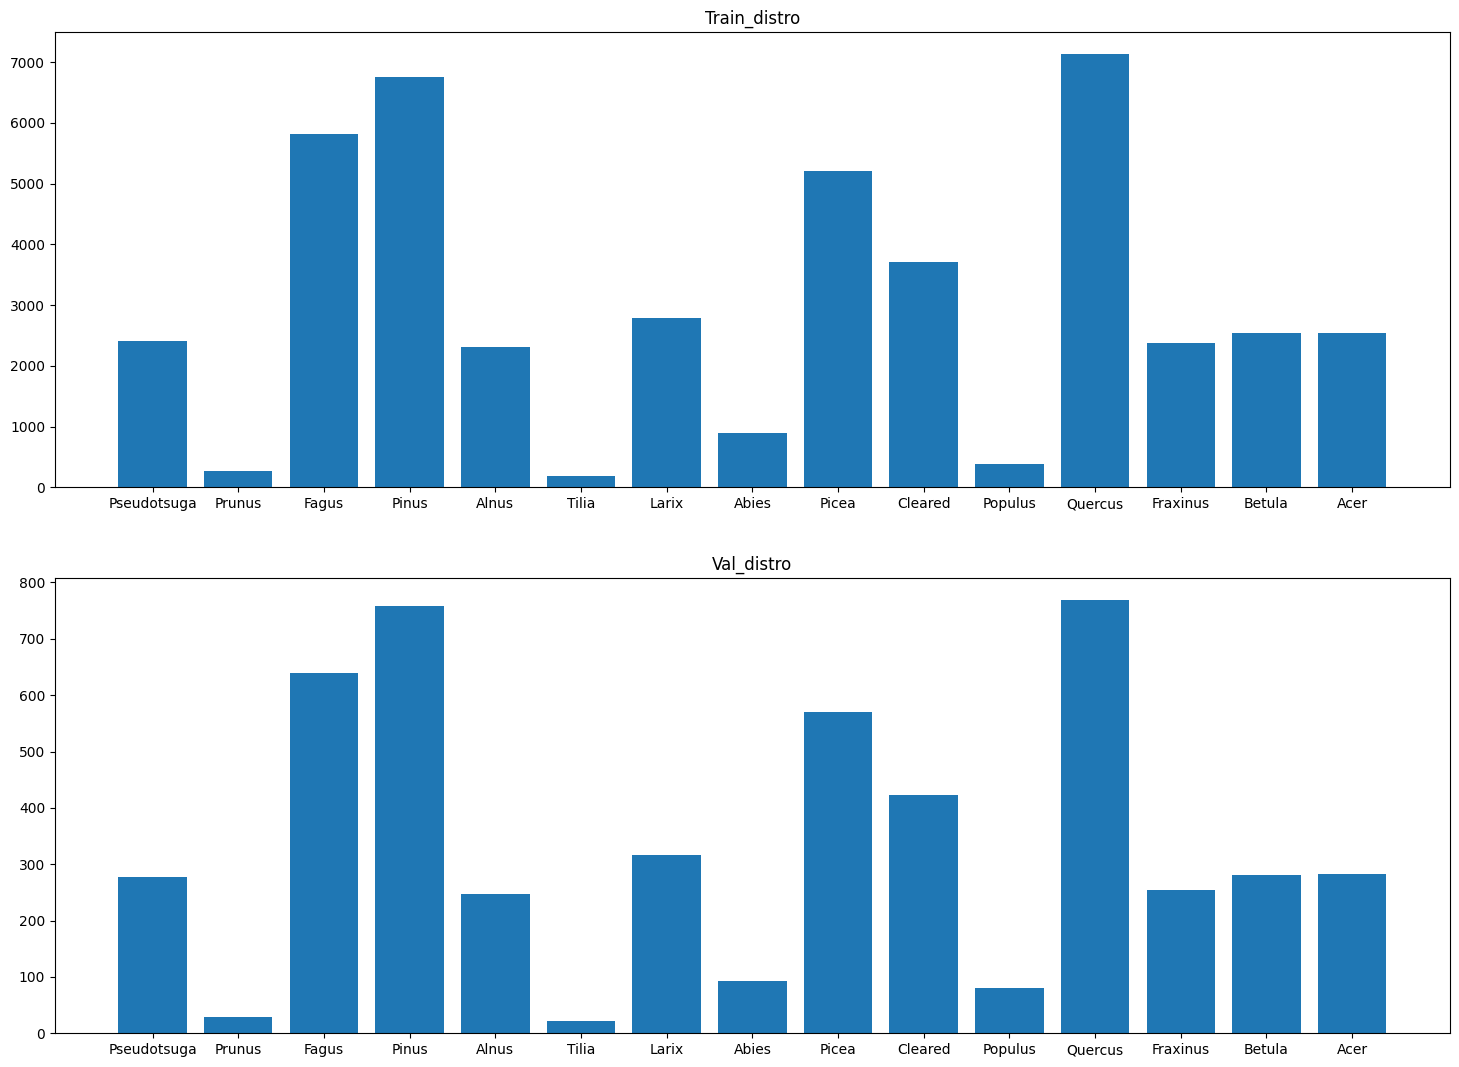

In [8]:

class_names = os.listdir('data/ims/sorted/s1_60m/train/')

class_counts_train = [len(os.listdir(os.path.join('data/ims/sorted/s1_60m/train/', class_name))) for class_name in class_names]
class_counts_val = [len(os.listdir(os.path.join('data/ims/sorted/s1_60m/test/', class_name))) for class_name in class_names]

f, ax = plt.subplots(2, 1, figsize=(18, 13))

ax[0].bar(class_names, class_counts_train)
ax[0].set_title('Train_distro')

ax[1].bar(class_names, class_counts_val)
ax[1].set_title('Val_distro')

f.savefig('class_distro.png')

Just because of curiosity let's see how different species look like. With naked eye it's not possible to classify anything here.

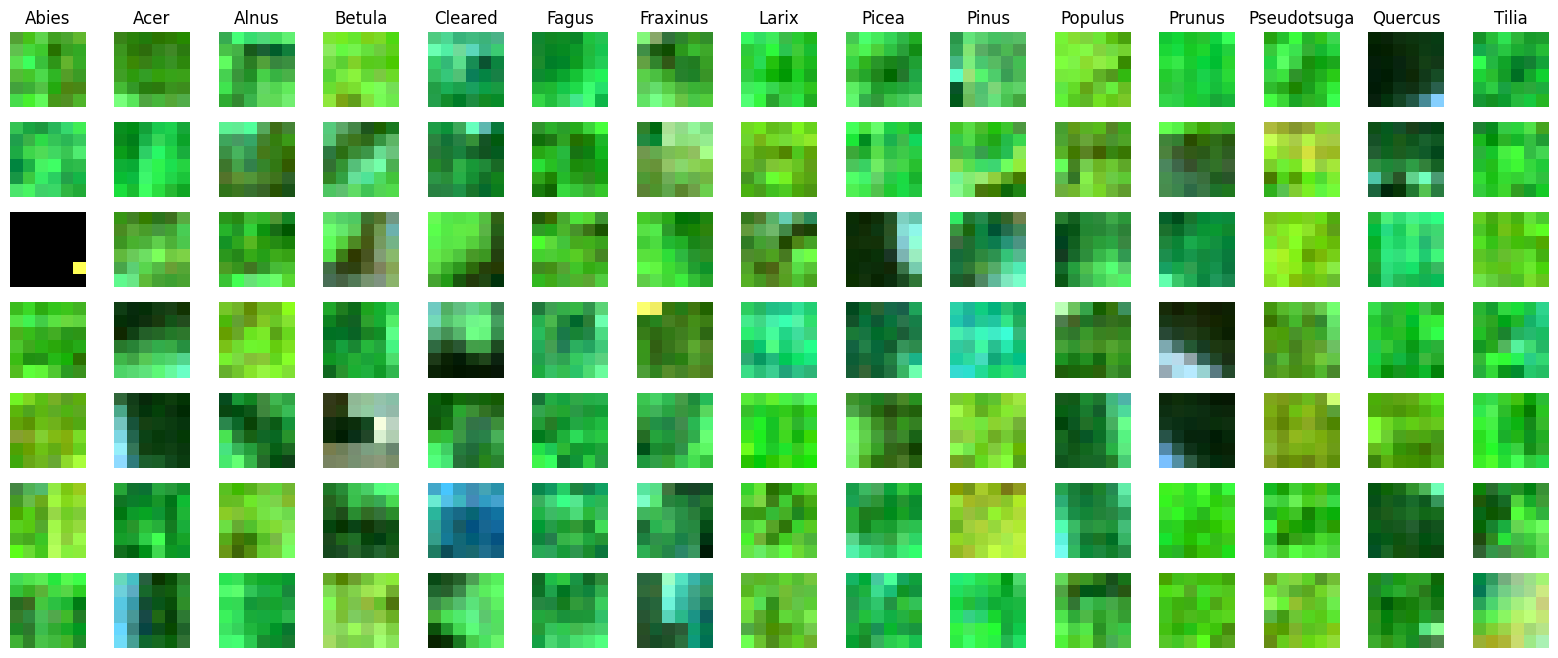

In [20]:
def vis_data(n_samples: int, y, x, channels):
    f, ax = plt.subplots(n_samples, len(ds_classes), figsize=(20, 8))
    # x = (x - x.mean(axis=(1), keepdims=True)) / (x - x.std(axis=(1), keepdims=True))
    idxes = {num: np.random.choice(np.where(y == num)[0], n_samples, replace=False) 
             for num in range(len(ds_classes)) if np.sum(y == num) >= n_samples}
    
    for i, indices in idxes.items():

        for j, idx in enumerate(indices):

            im = x[idx, [0,1,2], :, :]
            im = cv2.normalize(im, None, 0, 255, cv2.NORM_MINMAX)
            im = np.transpose(im, (1, 2, 0))
            im = np.uint8(im)[:, :, :]

            ax[j, i].imshow(im)
            ax[j, i].axis('off') 

            if not j:
                ax[j, i].set_title(ds_classes[i])

    plt.show()
    f.savefig('class_distro_ims.png')
     
%clear
vis_data(7, y_train_s1, X_train_s2, [0, 1, 2])



Combine all data into dicts for convinience.

In [10]:
all_datasets = {}
for name, req_indices in s2_datasets_descriptions.items():
    all_datasets[name] = transform_data(X_train_s2, y_train_s2, X_val_s2, y_val_s2, compute_sentinel2_indices, req_indices, channel_order_s2)

for name, req_indices in s1_datasets_descriptions.items():
    all_datasets[name] = transform_data(X_train_s1, y_train_s1, X_val_s1, y_val_s1, compute_sentinel1_indices, req_indices, channel_order_s1)


all_datasets['raw_s1+raw_s2'] = (np.hstack((all_datasets['s1_raw'][0], all_datasets['s2_raw'][0])), y_train_s1,
                                 np.hstack((all_datasets['s1_raw'][2], all_datasets['s2_raw'][2])), y_val_s1)

all_datasets['all_s1+all_s2'] = (np.hstack((all_datasets['s1_plus_rvi_ndpi_csi_vsi'][0], all_datasets['s2_plus_all_indexes'][0])), y_train_s1, 
                                 np.hstack((all_datasets['s1_plus_rvi_ndpi_csi_vsi'][2], all_datasets['s2_plus_all_indexes'][2])), y_val_s1)

PCA:

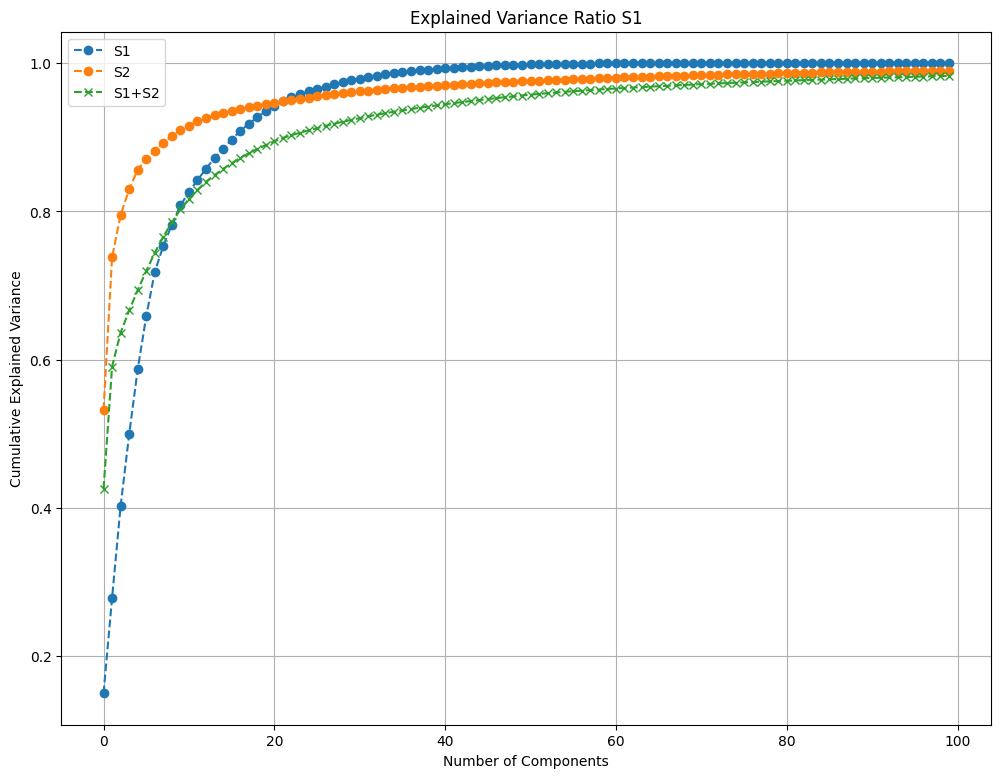

In [12]:
pca_s1 = PCA(n_components=100, svd_solver='full')
pca_s1.fit(all_datasets["s1_raw"][0])

pca_s2 = PCA(n_components=100, svd_solver='full')
pca_s2.fit(all_datasets["s2_raw"][0])

pca_s1s2 = PCA(n_components=100, svd_solver='full')
pca_s1s2.fit(all_datasets["raw_s1+raw_s2"][0])

plt.figure(figsize=(12, 9))
plt.plot(np.cumsum(pca_s1.explained_variance_ratio_), marker='o', linestyle='--', label='S1')
plt.plot(np.cumsum(pca_s2.explained_variance_ratio_), marker='o', linestyle='--', label='S2')
plt.plot(np.cumsum(pca_s1s2.explained_variance_ratio_), marker='x', linestyle='--', label='S1+S2')

plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance Ratio S1')
plt.legend()
plt.grid()

plt.savefig('explained_v.png')

Curiosity time 2: Let's see how samples are distributed in space of the PC1, PC2 and PC3:

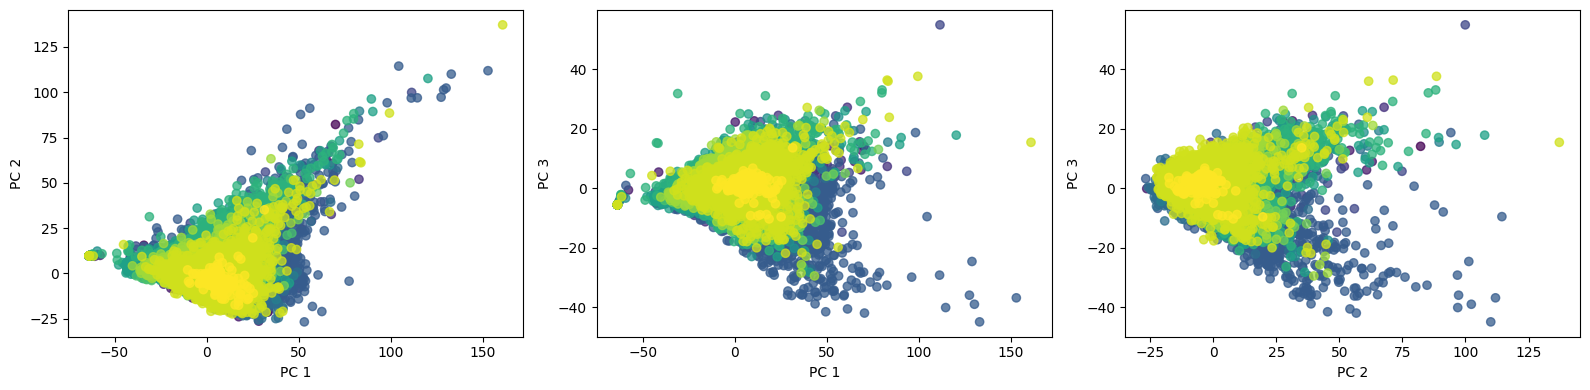

In [19]:
explained_var = pca_s2.explained_variance_ratio_

sorted_indices = np.argsort(-explained_var)
best_pcs = sorted_indices[:3]

pcaed_s2 = pca_s2.transform(all_datasets["s2_raw"][0])[:, best_pcs]

f, ax = plt.subplots(1, 3, figsize=(16, 4))

ax[0].scatter(pcaed_s2[:, 0], pcaed_s2[:, 1], c=y_train_s2, cmap='viridis', alpha=0.75)
ax[0].set_xlabel(f'PC {best_pcs[0]+1}')
ax[0].set_ylabel(f'PC {best_pcs[1]+1}')

ax[1].scatter(pcaed_s2[:, 0], pcaed_s2[:, 2], c=y_train_s2, cmap='viridis', alpha=0.75)
ax[1].set_xlabel(f'PC {best_pcs[0]+1}')
ax[1].set_ylabel(f'PC {best_pcs[2]+1}')

ax[2].scatter(pcaed_s2[:, 1], pcaed_s2[:, 2], c=y_train_s2, cmap='viridis', alpha=0.75)
ax[2].set_xlabel(f'PC {best_pcs[1]+1}')
ax[2].set_ylabel(f'PC {best_pcs[2]+1}')

plt.tight_layout()
plt.show()
f.savefig("pca_byplots.png")


In [13]:
pca_s1_40 = PCA(n_components=35, svd_solver='full')
pca_s1_40.fit(all_datasets["s1_raw"][0])
X_train_s1_pca = pca_s1_40.transform(all_datasets["s1_raw"][0])
X_val_s1_pca = pca_s1_40.transform(all_datasets["s1_raw"][2])


pca_s2_15 = PCA(n_components=15, svd_solver='full')
pca_s2_15.fit(all_datasets["s2_raw"][0])
X_train_s2_pca = pca_s2_15.transform(all_datasets["s2_raw"][0])
X_val_s2_pca = pca_s2_15.transform(all_datasets["s2_raw"][2])


all_datasets['s1_pca'] = (X_train_s1_pca, y_train_s1, X_val_s1_pca, y_val_s1)
all_datasets['s2_pca'] = (X_train_s2_pca, y_train_s2, X_val_s2_pca, y_val_s2)

Here we tried classical SVM. But: the dataset has 50k samples and 20 or 40 features. Roughly speaking SVM has O(N^2) complexity. Moreever sklearn computes it on one core, so classical SVM seems not working. At the same time, SVM problem solved with SGD works, see below.

In [14]:
algos = {
    "svm_l1": SGDClassifier(loss='hinge', penalty='l1', alpha=1.0/len(X_train_s1), max_iter=5000, random_state=42, n_jobs=-1),
    "svm_l2": SGDClassifier(loss='hinge', penalty='l2', alpha=1.0/len(X_train_s1), max_iter=5000, random_state=42, n_jobs=-1),

    "linreg_l1": SGDClassifier(loss='log_loss', penalty='l1', alpha=1.0/len(X_train_s1), max_iter=5000, random_state=42, n_jobs=-1),
    "linreg_l2": SGDClassifier(loss='log_loss', penalty='l2', alpha=1.0/len(X_train_s1), max_iter=5000, random_state=42, n_jobs=-1),

    "perceptron_l1": SGDClassifier(loss='perceptron', penalty='l1', alpha=1.0/len(X_train_s1), max_iter=5000, random_state=42, n_jobs=-1),
    "perceptron_l2": SGDClassifier(loss='perceptron', penalty='l2', alpha=1.0/len(X_train_s1), max_iter=5000, random_state=42, n_jobs=-1),

    "squared_hinge_l1": SGDClassifier(loss='squared_hinge', penalty='l1', alpha=1.0/len(X_train_s1), max_iter=7000, random_state=42, n_jobs=-1),
    "squared_hinge_l2": SGDClassifier(loss='squared_hinge', penalty='l2', alpha=1.0/len(X_train_s1), max_iter=7000, random_state=42, n_jobs=-1),

    "catboost": CatBoostClassifier(
                    iterations=500,       
                    learning_rate=0.01,   
                    depth=6,              
                    verbose=50,           
                    random_seed=42,       
                    task_type='GPU'
                    ) 
}

In [15]:
for ds_name, data in all_datasets.items():
    print(ds_name, end=' ')
    for d in data:
        print(d.shape, end=' ')
    print()

s2_raw (45337, 432) (45337,) (5044, 432) (5044,) 
s2_only_veg_indexes (45337, 252) (45337,) (5044, 252) (5044,) 
s2_plus_ndvi_indexes (45337, 432) (45337,) (5044, 432) (5044,) 
s2_plus_ndvi_evi_indexes (45337, 468) (45337,) (5044, 468) (5044,) 
s2_plus_ndvi_evi_ndwi_indexes (45337, 504) (45337,) (5044, 504) (5044,) 
s2_plus_all_indexes (45337, 648) (45337,) (5044, 648) (5044,) 
s1_raw (45337, 108) (45337,) (5044, 108) (5044,) 
s1_plus_rvi (45337, 144) (45337,) (5044, 144) (5044,) 
s1_plus_rvi_ndpi (45337, 180) (45337,) (5044, 180) (5044,) 
s1_plus_rvi_ndpi_csi (45337, 216) (45337,) (5044, 216) (5044,) 
s1_plus_rvi_ndpi_csi_vsi (45337, 252) (45337,) (5044, 252) (5044,) 
raw_s1+raw_s2 (45337, 540) (45337,) (5044, 540) (5044,) 
all_s1+all_s2 (45337, 900) (45337,) (5044, 900) (5044,) 
s1_pca (45337, 35) (45337,) (5044, 35) (5044,) 
s2_pca (45337, 15) (45337,) (5044, 15) (5044,) 


In [16]:
res = {}

for ds_name, data in all_datasets.items():
    for algo_name, algo in algos.items():
        X_train, y_train, X_val, y_val = data
        st = time.time()
        algo.fit(X_train, y_train)
        train_time = time.time() - st
        y_pred = algo.predict(X_val)

        accuracy = accuracy_score(y_val, y_pred)
        f1_micro = f1_score(y_val, y_pred, average="micro")
        f1_macro = f1_score(y_val, y_pred, average="macro")
        f1_weighted = f1_score(y_val, y_pred, average="weighted")

        res[(ds_name, algo_name)] = (accuracy, f1_micro, f1_macro, f1_weighted, train_time)
        print(f'{ds_name}-{algo_name}-{accuracy}-{f1_micro}-{f1_macro}-{f1_weighted}')

%clear
%time

s2_raw-svm_l1-0.4232751784298176-0.4232751784298176-0.27643525738413227-0.3886127158261664
s2_raw-svm_l2-0.369746233148295-0.369746233148295-0.26323162194326416-0.3690957028394898
s2_raw-linreg_l1-0.4536082474226804-0.4536082474226804-0.30065060005524874-0.42766040802308414
s2_raw-linreg_l2-0.4536082474226804-0.4536082474226804-0.2858702753810908-0.4178122232280147
s2_raw-perceptron_l1-0.40662172878667724-0.40662172878667724-0.2893200327550906-0.4001503536490358
s2_raw-perceptron_l2-0.43338620142743856-0.43338620142743856-0.2807879849431413-0.4028405758977521
s2_raw-squared_hinge_l1-0.2753766851704996-0.2753766851704996-0.22142039345635237-0.2721546890205391
s2_raw-squared_hinge_l2-0.3229579698651864-0.3229579698651864-0.2142856070107739-0.30123224905401347
0:	learn: 2.6797887	total: 98.8ms	remaining: 49.3s
50:	learn: 2.0859868	total: 1.95s	remaining: 17.2s
100:	learn: 1.8761551	total: 3.83s	remaining: 15.1s
150:	learn: 1.7613814	total: 5.74s	remaining: 13.3s
200:	learn: 1.6905142	tota

/home/al/envs/torch/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


s1_raw-squared_hinge_l1-0.10309278350515463-0.10309278350515463-0.05679871364505081-0.09220177336376269
s1_raw-squared_hinge_l2-0.12668517049960348-0.12668517049960348-0.07087869403327135-0.10964882717645587
0:	learn: 2.6998263	total: 15.3ms	remaining: 7.63s
50:	learn: 2.4563160	total: 687ms	remaining: 6.05s
100:	learn: 2.3535209	total: 1.27s	remaining: 5.04s
150:	learn: 2.2983442	total: 1.86s	remaining: 4.31s
200:	learn: 2.2647722	total: 2.45s	remaining: 3.64s
250:	learn: 2.2424711	total: 3.16s	remaining: 3.13s
300:	learn: 2.2263438	total: 3.72s	remaining: 2.46s
350:	learn: 2.2132390	total: 4.29s	remaining: 1.82s
400:	learn: 2.2022494	total: 4.88s	remaining: 1.2s
450:	learn: 2.1924208	total: 5.43s	remaining: 590ms
499:	learn: 2.1835740	total: 5.96s	remaining: 0us
s1_raw-catboost-0.2464314036478985-0.2464314036478985-0.09698758161868158-0.18054983793187973
s1_plus_rvi-svm_l1-0.1028945281522601-0.1028945281522601-0.03904091003046182-0.06884669150509562
s1_plus_rvi-svm_l2-0.1268834258524

/home/al/envs/torch/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


s1_plus_rvi-squared_hinge_l1-0.12014274385408406-0.12014274385408406-0.05756362968134184-0.09802603693407864
s1_plus_rvi-squared_hinge_l2-0.11459159397303727-0.11459159397303727-0.052471081155370816-0.08631015249469932
0:	learn: 2.6998259	total: 20ms	remaining: 9.99s
50:	learn: 2.4565159	total: 814ms	remaining: 7.16s
100:	learn: 2.3538387	total: 1.61s	remaining: 6.35s
150:	learn: 2.2985403	total: 2.39s	remaining: 5.53s
200:	learn: 2.2648813	total: 3.17s	remaining: 4.72s
250:	learn: 2.2427446	total: 3.94s	remaining: 3.91s
300:	learn: 2.2266764	total: 4.69s	remaining: 3.1s
350:	learn: 2.2136136	total: 5.49s	remaining: 2.33s
400:	learn: 2.2024871	total: 6.23s	remaining: 1.54s
450:	learn: 2.1927062	total: 7.05s	remaining: 766ms
499:	learn: 2.1839116	total: 7.79s	remaining: 0us
s1_plus_rvi-catboost-0.25337034099920697-0.25337034099920697-0.0979009213944875-0.18165628132460418
s1_plus_rvi_ndpi-svm_l1-0.10348929421094369-0.10348929421094369-0.037919851225780045-0.06734551558272009
s1_plus_rvi

/home/al/envs/torch/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


s1_plus_rvi_ndpi-squared_hinge_l1-0.12034099920697859-0.12034099920697859-0.037270989163703604-0.06851752382318085
s1_plus_rvi_ndpi-squared_hinge_l2-0.11221252973830294-0.11221252973830294-0.07523396057496991-0.11138278495834654
0:	learn: 2.6998261	total: 23ms	remaining: 11.5s
50:	learn: 2.4565149	total: 979ms	remaining: 8.62s
100:	learn: 2.3538375	total: 1.88s	remaining: 7.44s
150:	learn: 2.2985389	total: 2.83s	remaining: 6.55s
200:	learn: 2.2648809	total: 3.73s	remaining: 5.55s
250:	learn: 2.2427422	total: 4.63s	remaining: 4.59s
300:	learn: 2.2267104	total: 5.47s	remaining: 3.62s
350:	learn: 2.2136345	total: 6.33s	remaining: 2.69s
400:	learn: 2.2027138	total: 7.16s	remaining: 1.77s
450:	learn: 2.1928890	total: 8.01s	remaining: 870ms
499:	learn: 2.1840818	total: 8.83s	remaining: 0us
s1_plus_rvi_ndpi-catboost-0.25237906423473433-0.25237906423473433-0.09746303639079308-0.18063422864627116
s1_plus_rvi_ndpi_csi-svm_l1-0.10249801744647105-0.10249801744647105-0.03793630748452433-0.067362579

/home/al/envs/torch/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


s1_plus_rvi_ndpi_csi-squared_hinge_l1-0.12252180808881839-0.12252180808881839-0.03986598379046009-0.07382934142888112
s1_plus_rvi_ndpi_csi-squared_hinge_l2-0.10586835844567803-0.10586835844567803-0.06438023968664691-0.09176724568541163
0:	learn: 2.6998259	total: 27.1ms	remaining: 13.5s
50:	learn: 2.4564949	total: 1.1s	remaining: 9.71s
100:	learn: 2.3539123	total: 2.27s	remaining: 8.96s
150:	learn: 2.2986199	total: 3.36s	remaining: 7.77s
200:	learn: 2.2653570	total: 4.4s	remaining: 6.55s
250:	learn: 2.2432676	total: 5.43s	remaining: 5.39s
300:	learn: 2.2270469	total: 6.44s	remaining: 4.26s
350:	learn: 2.2138931	total: 7.44s	remaining: 3.16s
400:	learn: 2.2030164	total: 8.43s	remaining: 2.08s
450:	learn: 2.1931966	total: 9.41s	remaining: 1.02s
499:	learn: 2.1843822	total: 10.4s	remaining: 0us
s1_plus_rvi_ndpi_csi-catboost-0.2541633624107851-0.2541633624107851-0.09603364170071413-0.17751299361998588
s1_plus_rvi_ndpi_csi_vsi-svm_l1-0.0999206978588422-0.0999206978588422-0.03554858108026545-

/home/al/envs/torch/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


s1_plus_rvi_ndpi_csi_vsi-squared_hinge_l1-0.12212529738302934-0.12212529738302934-0.03979493421181819-0.07414118545854605
s1_plus_rvi_ndpi_csi_vsi-squared_hinge_l2-0.11399682791435369-0.11399682791435369-0.060501591616523354-0.09588228987040559
0:	learn: 2.6998257	total: 30.2ms	remaining: 15.1s
50:	learn: 2.4556917	total: 1.22s	remaining: 10.7s
100:	learn: 2.3520524	total: 2.41s	remaining: 9.52s
150:	learn: 2.2967216	total: 3.66s	remaining: 8.46s
200:	learn: 2.2631868	total: 4.84s	remaining: 7.19s
250:	learn: 2.2408153	total: 5.99s	remaining: 5.94s
300:	learn: 2.2246956	total: 7.17s	remaining: 4.74s
350:	learn: 2.2119790	total: 8.34s	remaining: 3.54s
400:	learn: 2.2013616	total: 9.43s	remaining: 2.33s
450:	learn: 2.1914275	total: 10.5s	remaining: 1.15s
499:	learn: 2.1827601	total: 11.6s	remaining: 0us
s1_plus_rvi_ndpi_csi_vsi-catboost-0.20459952418715305-0.20459952418715305-0.06738372491329402-0.12438044922612979
raw_s1+raw_s2-svm_l1-0.29401268834258526-0.29401268834258526-0.2224223458

/home/al/envs/torch/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


all_s1+all_s2-squared_hinge_l1-0.1161776367961935-0.1161776367961935-0.07661341277789553-0.1054613903757581
all_s1+all_s2-squared_hinge_l2-0.31007137192704204-0.31007137192704204-0.22410613436061108-0.30155725239955683
0:	learn: 2.6786052	total: 104ms	remaining: 51.9s
50:	learn: 2.0614354	total: 3.77s	remaining: 33.2s
100:	learn: 1.8448225	total: 7.56s	remaining: 29.9s
150:	learn: 1.7285449	total: 11.3s	remaining: 26.2s
200:	learn: 1.6576937	total: 15.1s	remaining: 22.4s
250:	learn: 1.6109078	total: 18.9s	remaining: 18.7s
300:	learn: 1.5778436	total: 22.5s	remaining: 14.9s
350:	learn: 1.5517877	total: 26.2s	remaining: 11.1s
400:	learn: 1.5302200	total: 29.8s	remaining: 7.36s
450:	learn: 1.5115848	total: 33.5s	remaining: 3.64s
499:	learn: 1.4951026	total: 37.1s	remaining: 0us
all_s1+all_s2-catboost-0.49385408406026965-0.49385408406026965-0.26052829750191103-0.4279440806755905


/home/al/envs/torch/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


s1_pca-svm_l1-0.08980967486122125-0.08980967486122125-0.04661140740270776-0.07381138863028014
s1_pca-svm_l2-0.14056304520222046-0.14056304520222046-0.06760660701791596-0.12088878106299167


/home/al/envs/torch/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


s1_pca-linreg_l1-0.09635210150674069-0.09635210150674069-0.0509105200918637-0.08237645913269247
s1_pca-linreg_l2-0.14314036478984932-0.14314036478984932-0.07417618025571421-0.12398697479313453


/home/al/envs/torch/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


s1_pca-perceptron_l1-0.12252180808881839-0.12252180808881839-0.048678192736228-0.08151377678164098
s1_pca-perceptron_l2-0.10111022997620936-0.10111022997620936-0.051657065302494774-0.08318307053960462


/home/al/envs/torch/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


s1_pca-squared_hinge_l1-0.09595559080095163-0.09595559080095163-0.04900684200895069-0.07885922955801192
s1_pca-squared_hinge_l2-0.14888977002379064-0.14888977002379064-0.08016773262799552-0.13421333935026442
0:	learn: 2.6985573	total: 9.63ms	remaining: 4.81s
50:	learn: 2.4460030	total: 388ms	remaining: 3.41s
100:	learn: 2.3452921	total: 742ms	remaining: 2.93s
150:	learn: 2.2924036	total: 1.19s	remaining: 2.74s
200:	learn: 2.2625784	total: 1.59s	remaining: 2.37s
250:	learn: 2.2439195	total: 1.95s	remaining: 1.94s
300:	learn: 2.2306536	total: 2.31s	remaining: 1.53s
350:	learn: 2.2204191	total: 2.65s	remaining: 1.13s
400:	learn: 2.2116463	total: 2.99s	remaining: 739ms
450:	learn: 2.2041624	total: 3.34s	remaining: 363ms
499:	learn: 2.1973566	total: 3.68s	remaining: 0us
s1_pca-catboost-0.2331482950039651-0.2331482950039651-0.09124148378694248-0.17169899239148453
s2_pca-svm_l1-0.31443298969072164-0.31443298969072164-0.17302178467834747-0.2570423751481918
s2_pca-svm_l2-0.25475812846946866-0.2

/home/al/envs/torch/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


s2_pca-squared_hinge_l1-0.0816812053925456-0.0816812053925456-0.07634299343965395-0.09023162846975442
s2_pca-squared_hinge_l2-0.19488501189532118-0.19488501189532118-0.13636463432233-0.19855088430936133
0:	learn: 2.6823107	total: 8.32ms	remaining: 4.15s
50:	learn: 2.1191380	total: 341ms	remaining: 3s
100:	learn: 1.9161078	total: 640ms	remaining: 2.53s
150:	learn: 1.8052234	total: 942ms	remaining: 2.18s
200:	learn: 1.7330443	total: 1.3s	remaining: 1.93s
250:	learn: 1.6836099	total: 1.72s	remaining: 1.71s
300:	learn: 1.6473734	total: 2.19s	remaining: 1.45s
350:	learn: 1.6175788	total: 2.52s	remaining: 1.07s
400:	learn: 1.5935069	total: 2.85s	remaining: 704ms
450:	learn: 1.5717948	total: 3.16s	remaining: 343ms
499:	learn: 1.5532112	total: 3.46s	remaining: 0us
s2_pca-catboost-0.4839413164155432-0.4839413164155432-0.25286283870607756-0.4143268320021963
CPU times: user 3 μs, sys: 0 ns, total: 3 μs
Wall time: 4.77 μs


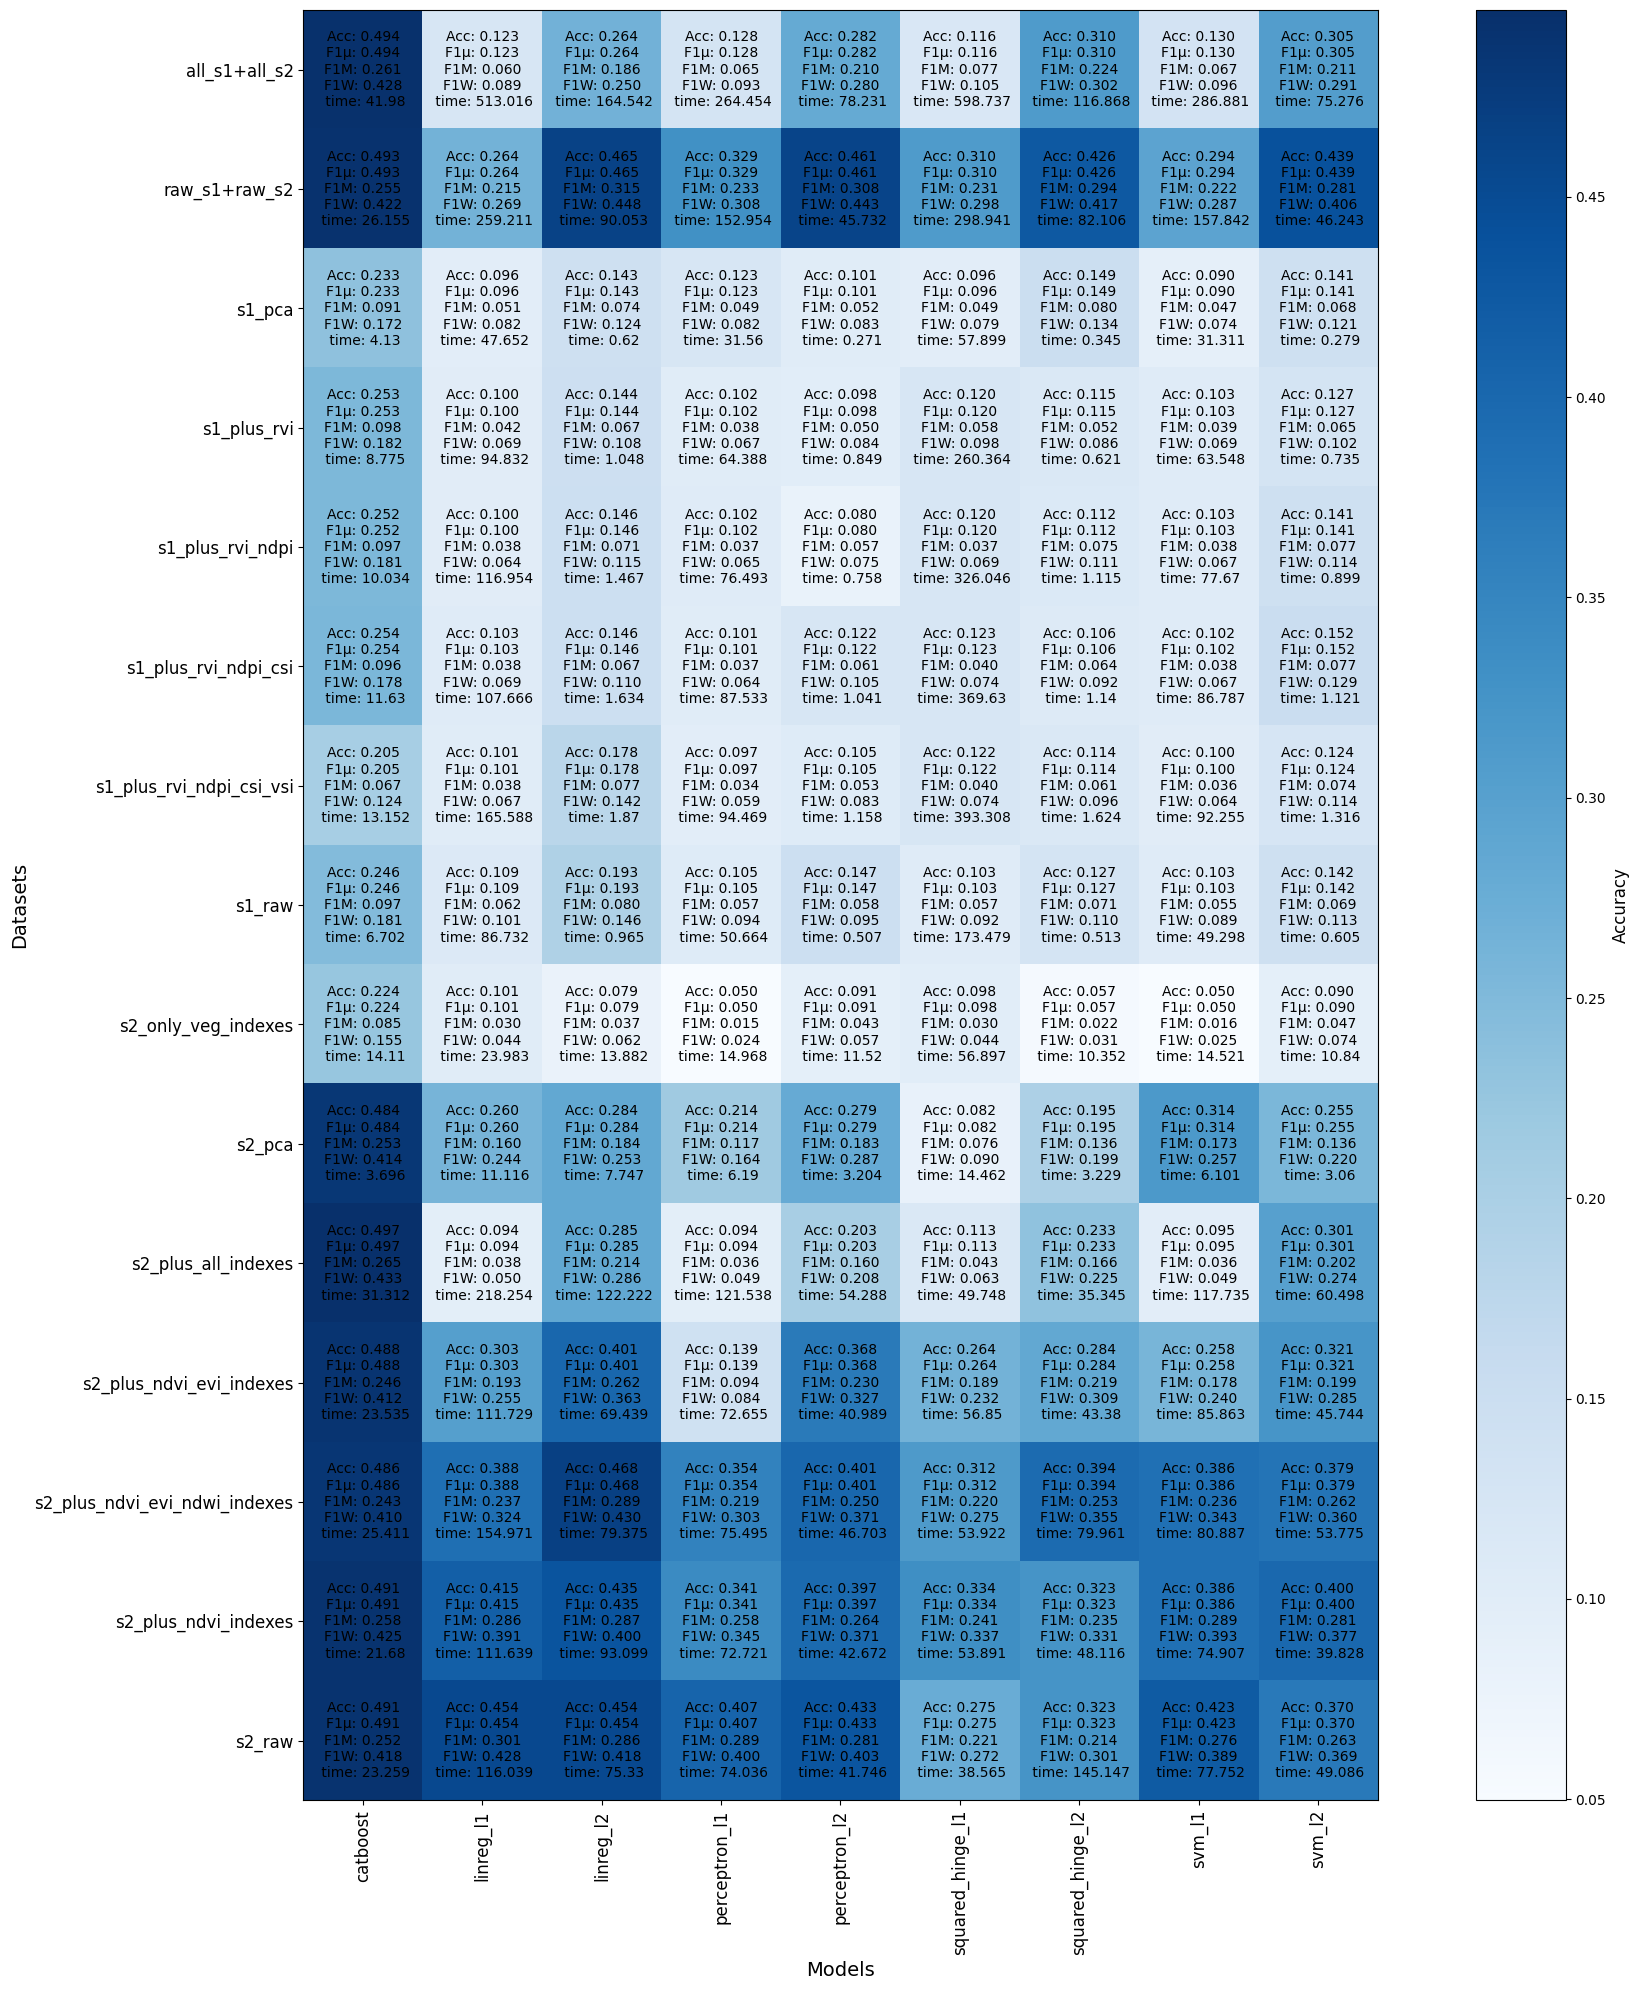

In [30]:
# Extract unique dataset and model names
datasets = sorted(set(key[0] for key in res.keys()))
models = sorted(set(key[1] for key in res.keys()))

# Create a matrix to store accuracy, F1 micro, and F1 macro
matrix = np.empty((len(datasets), len(models)), dtype=object)

# Fill the matrix with res
for (dataset, model), metrics in res.items():
    row = datasets.index(dataset)
    col = models.index(model)
    accuracy, f1_micro, f1_macro, f1_weighted, time = metrics
    matrix[row, col] = f"Acc: {accuracy:.3f}\nF1µ: {f1_micro:.3f}\nF1M: {f1_macro:.3f}\nF1W: {f1_weighted:.3f}\n time: {round(time, 3)}"

# Plot the matrix
fig, ax = plt.subplots(figsize=(20, 20))

# Use a heatmap for visualization
heatmap = np.zeros_like(matrix, dtype=float)  # Placeholder for color intensity
for row in range(len(datasets)):
    for col in range(len(models)):
        heatmap[row, col] = res[(datasets[row], models[col])][0]  # Use accuracy for intensity

im = ax.imshow(heatmap, cmap="Blues")

# Add annotations
for i in range(len(datasets)):
    for j in range(len(models)):
        ax.text(j, i, matrix[i, j], ha="center", va="center", fontsize=10, color="black")

# Set axis labelsst
ax.set_xticks(np.arange(len(models)))
ax.set_yticks(np.arange(len(datasets)))
ax.set_xticklabels(models, fontsize=12, rotation=90)
ax.set_yticklabels(datasets, fontsize=12)
plt.xlabel("Models", fontsize=14)
plt.ylabel("Datasets", fontsize=14)

# Add a colorbar to indicate accuracy intensity
cbar = plt.colorbar(im, ax=ax)
cbar.set_label("Accuracy", fontsize=12)

plt.tight_layout()
plt.show()

In [203]:
metrics = ['accuracy', 'f1_micro', 'f1_macro', 'f1_weighted']

matrix = [None] * len(metrics)

for metric in metrics:

    i = metrics.index(metric)

    best_try_metric = 0
    for (dataset, model), info in res.items():
        time = info[-1]
        
        m = info[i]
    
        if m > best_try_metric:
            best_try_metric = m
            matrix[i] = [metric, dataset, model, m, 'time:' + str(round(time, 3))]


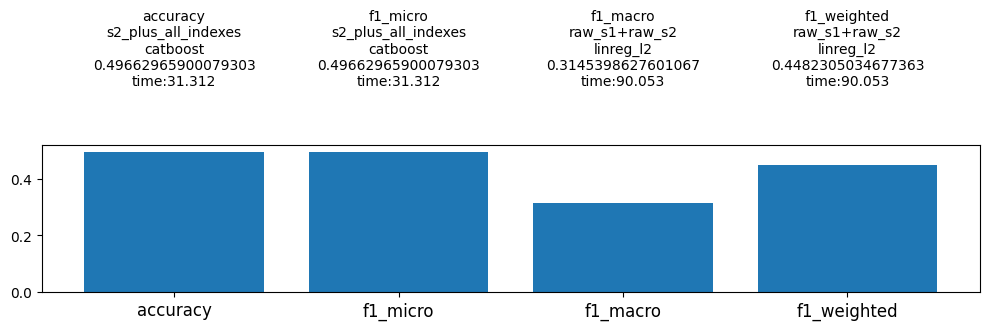

In [202]:
fig, ax = plt.subplots(figsize=(10, 7))

heatmap = np.array([x[3] for x in matrix])
plt.bar(range(4), heatmap)

plot_matrix = np.empty(len(matrix))

ax.set_xticks(np.arange(len(matrix)))

ax.set_xticklabels(list(map(lambda x: x[0], matrix)), fontsize=12)

for i, m in enumerate(matrix):
    m = list(map(lambda x: str(x), m))
    
    ax.text(i, 1, '\n'.join(m), ha="center", va="top", fontsize=10, color="black")



plt.tight_layout()
plt.show()


In [33]:
with open ('res-table.txt', 'w') as f:
    for (dataset, model), metrics in res.items():
        accuracy, f1_micro, f1_macro, f1_weighted, time = metrics
        f.write(f"| {dataset} | {model} | {accuracy:.3f} | {f1_micro:.3f} | {f1_macro:.3f} | {f1_weighted:.3f} | {round(time, 3)} |\n")

In [42]:
cat res-table.txt

| s2_raw | svm_l1 | 0.423 | 0.423 | 0.276 | 0.389 | 77.752 |
| s2_raw | svm_l2 | 0.370 | 0.370 | 0.263 | 0.369 | 49.086 |
| s2_raw | linreg_l1 | 0.454 | 0.454 | 0.301 | 0.428 | 116.039 |
| s2_raw | linreg_l2 | 0.454 | 0.454 | 0.286 | 0.418 | 75.33 |
| s2_raw | perceptron_l1 | 0.407 | 0.407 | 0.289 | 0.400 | 74.036 |
| s2_raw | perceptron_l2 | 0.433 | 0.433 | 0.281 | 0.403 | 41.746 |
| s2_raw | squared_hinge_l1 | 0.275 | 0.275 | 0.221 | 0.272 | 38.565 |
| s2_raw | squared_hinge_l2 | 0.323 | 0.323 | 0.214 | 0.301 | 145.147 |
| s2_raw | catboost | 0.491 | 0.491 | 0.252 | 0.418 | 23.259 |
| s2_only_veg_indexes | svm_l1 | 0.050 | 0.050 | 0.016 | 0.025 | 14.521 |
| s2_only_veg_indexes | svm_l2 | 0.090 | 0.090 | 0.047 | 0.074 | 10.84 |
| s2_only_veg_indexes | linreg_l1 | 0.101 | 0.101 | 0.030 | 0.044 | 23.983 |
| s2_only_veg_indexes | linreg_l2 | 0.079 | 0.079 | 0.037 | 0.062 | 13.882 |
| s2_only_veg_indexes | perceptron_l1 | 0.050 | 0.050 | 0.015 | 0.024 | 14.968 |
| s2_only_veg_indexes | pe

Let's see the a confusion matrix:

In [ ]:
the_best_classifier = CatBoostClassifier(
                    iterations=500,       
                    learning_rate=0.01,   
                    depth=6,              
                    verbose=50,           
                    random_seed=42,       
                    task_type='GPU'
                    )

the_best_classifier.fit(all_datasets['s2_plus_all_indexes'][0], all_datasets['s2_plus_all_indexes'][1])


0:	learn: 2.6786053	total: 77.3ms	remaining: 38.6s
50:	learn: 2.0614354	total: 2.85s	remaining: 25.1s
100:	learn: 1.8450658	total: 5.64s	remaining: 22.3s
150:	learn: 1.7300818	total: 8.47s	remaining: 19.6s
200:	learn: 1.6608379	total: 11.3s	remaining: 16.8s
250:	learn: 1.6159244	total: 14.1s	remaining: 14s
300:	learn: 1.5840285	total: 16.8s	remaining: 11.1s
350:	learn: 1.5590272	total: 19.4s	remaining: 8.25s
400:	learn: 1.5393423	total: 22.1s	remaining: 5.46s
450:	learn: 1.5214184	total: 24.8s	remaining: 2.69s
499:	learn: 1.5068749	total: 27.4s	remaining: 0us


In [19]:
best_predictions = the_best_classifier.predict(all_datasets['s2_plus_all_indexes'][2].squeeze())

Validation Accuracy: 49.66%


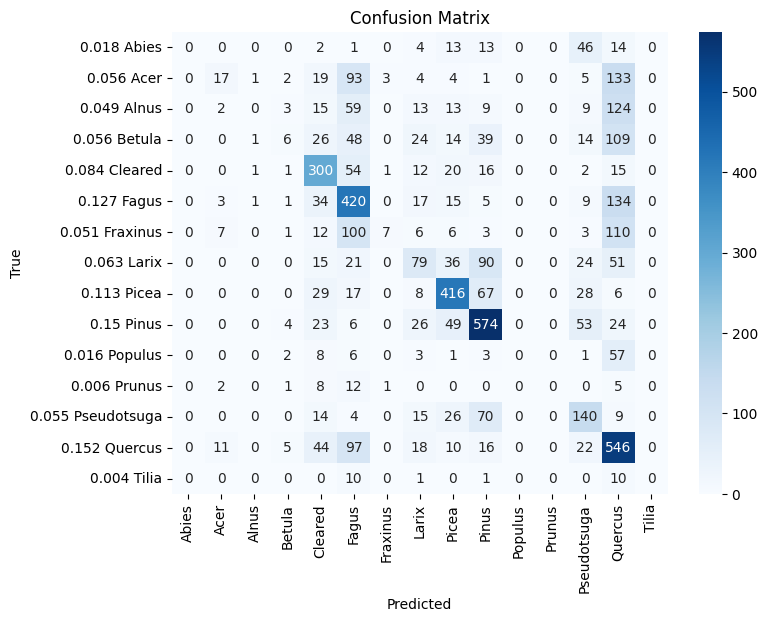

In [20]:
confussion_matrix(all_datasets['s2_plus_all_indexes'][3], best_predictions)

In [21]:
patch_distros_true = best_predictions.squeeze() == y_val_s2
distros_for_true = full_distrib_val_s2[patch_distros_true].squeeze()
distros_for_false = full_distrib_val_s2[~patch_distros_true].squeeze()


In [22]:
unique_counts_true = np.apply_along_axis(lambda row: len(np.unique(row)), axis=1, arr=distros_for_true)
unique_counts_false = np.apply_along_axis(lambda row: len(np.unique(row)), axis=1, arr=distros_for_false)

We clearly see that the model tends to make mistakes on samples where more than one species is depicted.  
**So, the approach with predicting the most abundant class when the patches also contain a lot of different species / ground is very coarse.**

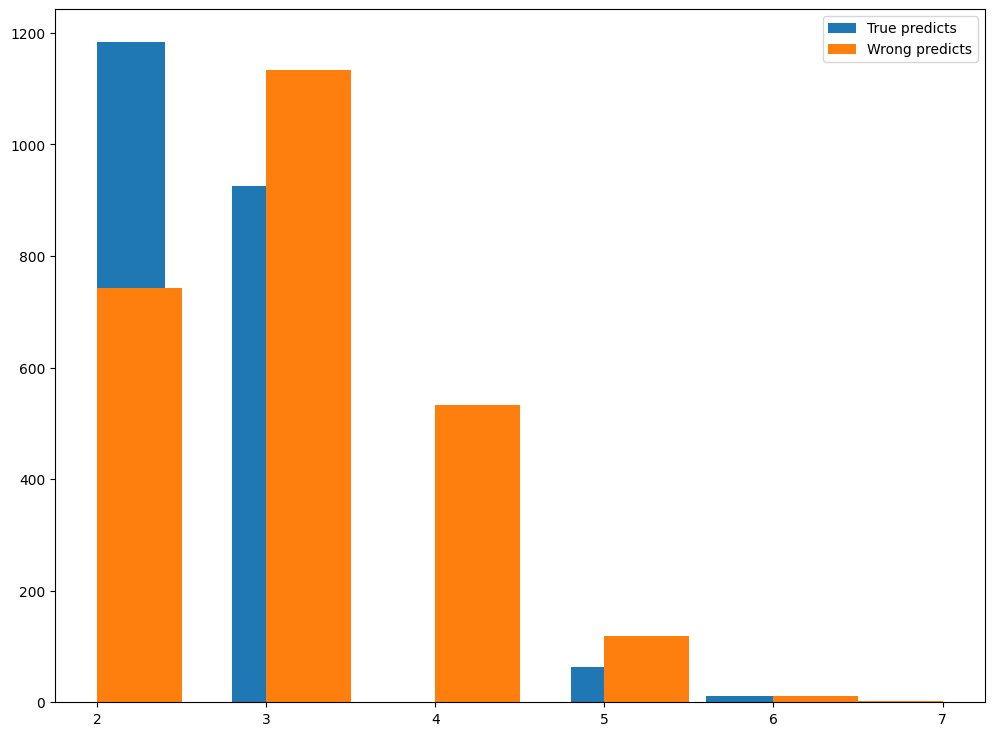

In [23]:
plt.figure(figsize=(12, 9))

plt.hist(unique_counts_true, label='True predicts')
plt.hist(unique_counts_false, label='Wrong predicts')
plt.legend()

It's not straightforward to set up a multi-regression task (but not the classification of the most abundant species like above) with catboost and other classical ML algorythms so let us try DL methods where the problem may be solved trivially with MSELoss.

Let's try optuna to squeeze as much as possible from catboost:

In [24]:
def objective(trial):
    params = {
        "iterations": 500,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 10),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
        "task_type": 'GPU'
    }

    model = CatBoostClassifier(**params, silent=True)
    model.fit(all_datasets['all_s1+all_s2'][0], all_datasets['all_s1+all_s2'][1])
    predictions = model.predict(all_datasets['all_s1+all_s2'][2])
    accuracy = accuracy_score(all_datasets['all_s1+all_s2'][3], predictions)
    return accuracy

In [25]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=15)

[I 2025-02-26 23:22:02,280] A new study created in memory with name: no-name-fe905dcc-5304-45e7-bd8b-c1ea23717202
[I 2025-02-26 23:22:13,230] Trial 0 finished with value: 0.4238699444885012 and parameters: {'learning_rate': 0.008044124338360882, 'depth': 1, 'min_data_in_leaf': 94}. Best is trial 0 with value: 0.4238699444885012.
[I 2025-02-26 23:23:24,061] Trial 1 finished with value: 0.46946867565424266 and parameters: {'learning_rate': 0.002565668340849908, 'depth': 7, 'min_data_in_leaf': 30}. Best is trial 0 with value: 0.4238699444885012.
[I 2025-02-26 23:23:36,508] Trial 2 finished with value: 0.42089611419508327 and parameters: {'learning_rate': 0.0025640191152879726, 'depth': 2, 'min_data_in_leaf': 86}. Best is trial 2 with value: 0.42089611419508327.
[I 2025-02-26 23:23:51,867] Trial 3 finished with value: 0.45796986518636 and parameters: {'learning_rate': 0.007645285829264128, 'depth': 3, 'min_data_in_leaf': 6}. Best is trial 2 with value: 0.42089611419508327.
[I 2025-02-26 23

So we can squeeze a few hunderts of accuracy from catboost with optuna.

In [26]:
test = CatBoostClassifier(**study.trials[0].params, iterations=500)


test.fit(all_datasets['all_s1+all_s2'][0], all_datasets['all_s1+all_s2'][1])
predictions = test.predict(all_datasets['all_s1+all_s2'][2])
accuracy = accuracy_score(all_datasets['all_s1+all_s2'][3], predictions)

0:	learn: 2.6975541	total: 73.5ms	remaining: 36.7s
1:	learn: 2.6872889	total: 142ms	remaining: 35.4s
2:	learn: 2.6775976	total: 212ms	remaining: 35.2s
3:	learn: 2.6683200	total: 283ms	remaining: 35.1s
4:	learn: 2.6590251	total: 353ms	remaining: 35s
5:	learn: 2.6498864	total: 423ms	remaining: 34.9s
6:	learn: 2.6408279	total: 493ms	remaining: 34.7s
7:	learn: 2.6321428	total: 564ms	remaining: 34.7s
8:	learn: 2.6239752	total: 634ms	remaining: 34.6s
9:	learn: 2.6156774	total: 705ms	remaining: 34.6s
10:	learn: 2.6075987	total: 776ms	remaining: 34.5s
11:	learn: 2.5996469	total: 846ms	remaining: 34.4s
12:	learn: 2.5918597	total: 916ms	remaining: 34.3s
13:	learn: 2.5843776	total: 986ms	remaining: 34.2s
14:	learn: 2.5767379	total: 1.05s	remaining: 34.1s
15:	learn: 2.5697792	total: 1.13s	remaining: 34.1s
16:	learn: 2.5626379	total: 1.2s	remaining: 34s
17:	learn: 2.5554020	total: 1.26s	remaining: 33.9s
18:	learn: 2.5485391	total: 1.33s	remaining: 33.8s
19:	learn: 2.5416592	total: 1.4s	remaining: 3